# Data visualization 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import torch

from torch.utils.data import DataLoader
from skimage.measure import perimeter, regionprops
from pathlib import Path

import utils

# directorys with data and to store training checkpoints and logs
DATA_DIR = Path.cwd().parent.parent / "DevelopmentData"

In [2]:
# data settings 
IMAGE_SIZE = [64, 64]
BATCH_SIZE = 1290

# find patient folders in training directory
# excluding hidden folders (start with .)
patients = [
    path
    for path in DATA_DIR.glob("*")
    if not any(part.startswith(".") for part in path.parts)
]

# load training data and create DataLoader with batching and shuffling
dataset = utils.ProstateMRDataset(patients, IMAGE_SIZE)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    pin_memory=True
)

## Pixel count & perimeter to area ratio (circularity)

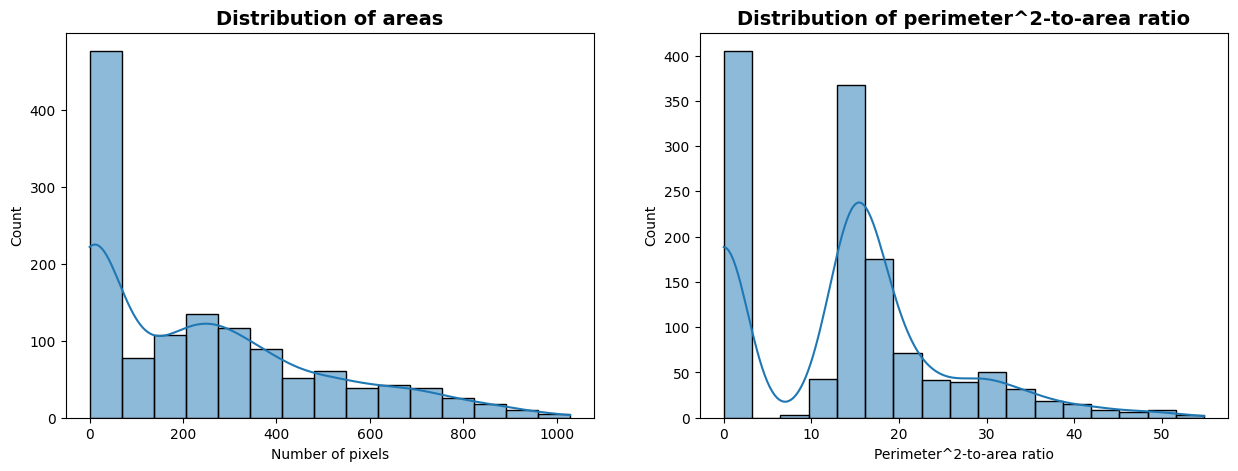

In [3]:
pixel_count = []
perimeter_area_ratio = []

# Loop over segmentation inside dataloader
for total_prostate, total_segment in dataloader:
    # Loop over individual segmentations
    for segment in total_segment:
        # Calculate number of pixels
        segment = segment.squeeze().numpy()
        num_pixels = np.sum(segment)
        pixel_count.append(int(num_pixels))

        if num_pixels != 0:
            circum = perimeter(segment)
            perimeter_area_ratio.append(float(circum**2/num_pixels))
        else:
            perimeter_area_ratio.append(0)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(pixel_count, kde=True, ax=ax[0])
sns.histplot(perimeter_area_ratio, kde=True, ax=ax[1])
ax[0].set_title("Distribution of areas", fontsize=14, fontweight='bold')
ax[0].set_xlabel("Number of pixels")
ax[1].set_title("Distribution of perimeter^2-to-area ratio", fontsize=14, fontweight="bold")
ax[1].set_xlabel("Perimeter^2-to-area ratio");

## Centroid position & segmentation heatmap

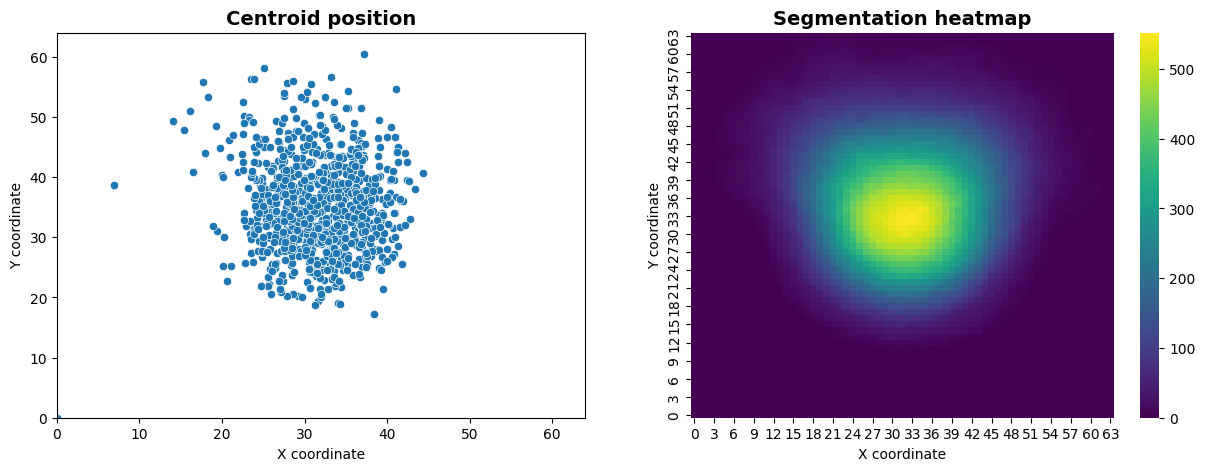

In [4]:
segmentation_heatmap = np.zeros((64, 64))
centroid_x = []
centroid_y = []

# Loop over segmentation inside dataloader
for total_prostate, total_segment in dataloader:
    # Loop over individual segmentations
    for segment in total_segment:
        # Calculate centroid
        segment = segment.squeeze().numpy()
        num_pixels = np.sum(segment)

        # segmenation heatmap
        segmentation_heatmap = np.add(segmentation_heatmap, segment)

        if num_pixels != 0:
            props = regionprops(segment)
            centroid = props[0].centroid
            centroid_x.append(float(centroid[1]))
            centroid_y.append(float(centroid[0]))
        else:
            centroid_x.append(0)
            centroid_y.append(0)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x=centroid_x, y=centroid_y, ax=ax[0])
sns.heatmap(segmentation_heatmap, cmap="viridis", ax=ax[1])
ax[0].set_title("Centroid position", fontsize=14, weight="bold")
ax[0].set_xlabel("X coordinate")
ax[0].set_ylabel("Y coordinate")
ax[0].set_xlim([0, 64])
ax[0].set_ylim([0, 64])
ax[1].set_title("Segmentation heatmap", fontsize=14, weight="bold")
ax[1].set_xlabel("X coordinate")
ax[1].set_ylabel("Y coordinate")
ax[1].invert_yaxis();

In [5]:
# Loop over segmentation inside dataloader
for total_prostate, total_segment in dataloader:
    x = torch.cat((total_prostate, total_segment), 1)

In [11]:
total_segment.to(total_prostate.dtype).dtype

torch.float32